In [5]:
%load_ext autoreload
%autoreload 2

from functools import lru_cache
import sys
sys.path.append("../")
from os.path import join
from IPython.display import display
from functools import partial

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=False)
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, sem
from scipy.fft import fft2
import scipy
import joblib
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from skimage.segmentation import mark_boundaries
from scipy.stats import pearsonr
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_rows', 128)

from spurious_ml.models.torch_utils import archs
from spurious_ml.variables import auto_var
from params import *
from utils import params_to_dataframe

fontsize=18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def cnn_pred_fn(X, model, device="cuda"):
    if len(X.shape) == 4:
        X = X.transpose(0, 3, 1, 2)
        
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=128)
    
    model.to(device).eval()
    fetX = []
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

def mlp_pred_fn(X, model, device="cuda"):
    dset = torch.utils.data.TensorDataset(torch.from_numpy(X.reshape(len(X), -1)).float())
    loader = torch.utils.data.DataLoader(dset, batch_size=256)
    
    model.to(device).eval()
    fetX = []
    for (x, ) in tqdm(loader, desc="[pred_fn]"):
        fetX.append(model(x.to(device)).cpu().detach().numpy())
    fetX = np.concatenate(fetX, axis=0)
    return fetX

In [3]:
params = {
    "mnist": [
        ["CNN002", "CNN", "../models/train_classifier/128-mnist-70-0.01-ce-tor-CNN002-0.0-adam-0-0.0.pt"],
        ["MLP", "small MLP", "../models/train_classifier/128-mnist-70-0.01-ce-tor-MLP-0.0-adam-0-0.0.pt"],
        ["LargeMLP", "MLP", "../models/train_classifier/128-mnist-70-0.01-ce-tor-LargeMLP-0.0-adam-0-0.0.pt"],
        ["LargeMLPv2", "large MLP", "../models/train_classifier/128-mnist-70-0.01-ce-tor-LargeMLPv2-0.0-adam-0-0.0.pt"],
    ],
    "fashion": [
        ["CNN002", "CNN", "../models/train_classifier/128-fashion-70-0.01-ce-tor-CNN002-0.0-adam-0-0.0.pt"],
        ["MLP", "small MLP", "../models/train_classifier/128-fashion-70-0.01-ce-tor-MLP-0.0-adam-0-0.0.pt"],
        ["LargeMLP", "MLP", "../models/train_classifier/128-fashion-70-0.01-ce-tor-LargeMLP-0.0-adam-0-0.0.pt"],
        ["LargeMLPv2", "large MLP", "../models/train_classifier/128-fashion-70-0.01-ce-tor-LargeMLPv2-0.0-adam-0-0.0.pt"],
    ],
    "cifar10": [
        ["altResNet20Norm02", "ResNet20", "../models/train_classifier/128-cifar10-70-0.1-aug01-ce-tor-altResNet20Norm02-0.9-sgd-0-0.0001.pt"],
        ["altResNet32Norm02", "ResNet32", "../models/train_classifier/128-cifar10-70-0.1-aug01-ce-tor-altResNet32Norm02-0.9-sgd-0-0.0001.pt"],
        ["altResNet110Norm02", "ResNet110", "../models/train_classifier/128-cifar10-70-0.1-aug01-ce-tor-altResNet110Norm02-0.9-sgd-0-0.0001.pt"],
        ["Vgg16Norm02", "Vgg16", "../models/train_classifier/128-cifar10-70-0.01-aug01-ce-tor-Vgg16Norm02-0.9-sgd-0-0.0001.pt"],
    ],
}

def occlude_X(X, occlude, random_state):
    if occlude == 0:
        return np.copy(X)
    if occlude == 1:
        return np.zeros_like(X)
    retX = []
    tX = np.copy(X.reshape(X.shape[0], X.shape[1] * X.shape[2], X.shape[3]))
    inds = np.where(tX != 0)
    n_blocked = int(X.shape[1] * X.shape[2] * occlude)
    blocked_pixels = random_state.choice(np.arange(2), size=len(inds[1]), p=[1-occlude, occlude], replace=True)
    for i in tqdm(range(len(X))):
        pixel_no = inds[1][inds[0] == i][blocked_pixels[inds[0] == i] == 1]
        tX[i][pixel_no] = 0
        retX.append(tX[i].reshape(1, X.shape[1], X.shape[2], X.shape[3]))
    return np.concatenate(retX, axis=0)


In [14]:
n_samples = 500

results = {}
for ds_name, ds_params in params.items():
    trnX, trny, tstX, tsty, spurious_ind = auto_var.get_var_with_argument("dataset", ds_name)
    n_classes = len(np.unique(trny))
    n_channels = trnX.shape[-1]

    ind = np.random.RandomState(0).choice(np.arange(len(trny)), size=n_samples, replace=False)
    occuluded_Xs = []
    for p in range(51):
        occuluded_Xs.append(occlude_X(trnX[ind], p/50, np.random.RandomState(0)))
        
    for arch_name, arch_shown_name, model_path in ds_params:
        model = getattr(archs, arch_name)(n_features=(np.prod(trnX.shape[1:]), ), n_channels=n_channels, n_classes=n_classes)
        model.load_state_dict(torch.load(model_path)['model_state_dict'])
    
        preds = []
        for p in range(51):
            occ_trnX = occuluded_Xs[p]
            if "MLP" in arch_name:
                pred = mlp_pred_fn(occ_trnX, model, )[None, :, :]
            else:
                pred = cnn_pred_fn(occ_trnX, model, )[None, :, :]
            preds.append(pred)
        preds = scipy.special.softmax(np.concatenate(preds), axis=2)
        
        ttt = []
        for i in range(n_samples):
            ttt.append(preds[:, i, trny[ind[i]]])
        results[(ds_name, arch_name)] = (np.mean(ttt), )
        plt.plot(np.arange(51)/50, np.mean(ttt, axis=0), label=arch_shown_name)
    plt.ylabel("Probability", fontsize=fontsize)
    plt.xlabel("Portion of pixels removed", fontsize=fontsize)
    plt.xticks(xaxis[::10], labels=xaxis[::10], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(f"./figs/pixel_removal/{ds_name}.png")
    plt.close()


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

[pred_fn]:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
data = {}
for ds_name, ds_params in params.items():
    trnX, trny, tstX, tsty, spurious_ind = auto_var.get_var_with_argument("dataset", ds_name)
    n_classes = len(np.unique(trny))
    n_channels = trnX.shape[-1]

    for arch_name, arch_shown_name, model_path in ds_params:
        if arch_shown_name in data:
            continue
        model = getattr(archs, arch_name)(n_features=(np.prod(trnX.shape[1:]), ), n_channels=n_channels, n_classes=n_classes)
        
        model_parameters = filter(lambda p: p.requires_grad, model.parameters())
        data[arch_shown_name] = sum([np.prod(p.size()) for p in model_parameters])

In [14]:
data

{'CNN': 312202,
 'small MLP': 203530,
 'MLP': 335114,
 'large MLP': 932362,
 'ResNet20': 269722,
 'ResNet32': 464154,
 'ResNet110': 1727962,
 'Vgg16': 134301514}

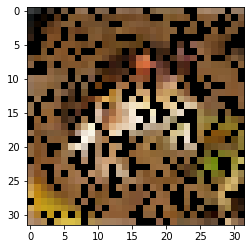

In [122]:
plt.imshow(occ_trnX[0])